# Random Graphs

The goal of this notebook is to explore some of theory behind Erdös-Rényi random binomial graphs and propose extensions to the methodology to model heterogeneous networks. Hopefully, some of this will be useful for understanding how the properties of networks of biological data change when they are integrated.

In [1]:
import networkx as nx

import numpy as np
from numpy.random import uniform

import itertools as itt
from itertools import combinations, product, accumulate

import pandas as pd
import scipy as scp
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 9.0)
np.random.seed(seed=127)

# Example 1: Small Erdös-Rényi Graph

This example shows an Erdös-Rényi random binomial graph $G(n, p)$ over $n$ nodes where an edge is added with uniform probability $p$ for each of the $n \choose 2$ possible edges.

$P(deg(v)=k)={n-1 \choose k}p^k(1-p)^{n-1-k} \sim Binomial(n,p)$

For large $n$, $Binomial(n,p) \approx \mathcal{N}(\mu = np, \sigma = \sqrt{np(1-p)})$.

[]

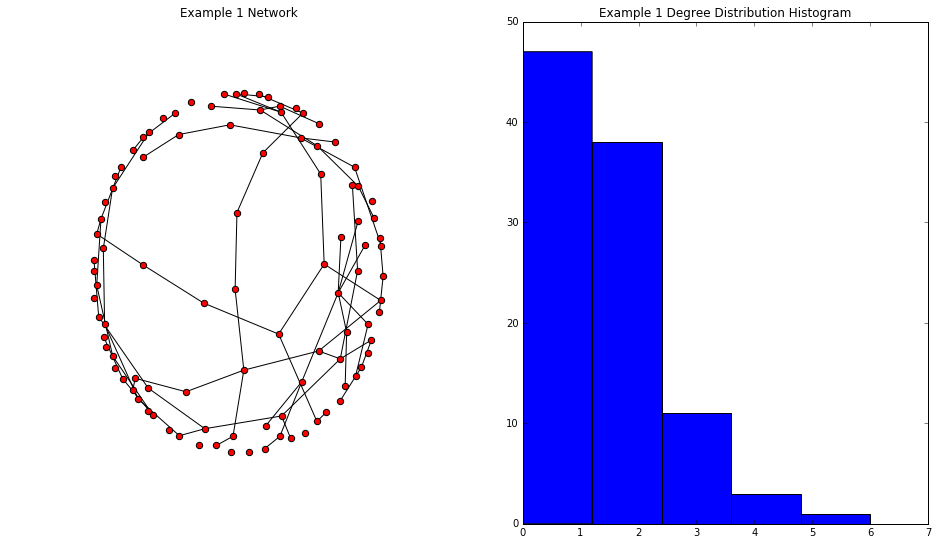

In [2]:
n = 100
p = 0.015
g = nx.Graph()

for node in range(n):
    g.add_node(node)

for edge in combinations(range(n), 2):
    if uniform() < p:
        g.add_edge(*edge)

f, ax = plt.subplots(1, 2)

ax[0].set_title("Example 1 Network")
nx.draw_spring(g , node_size=40, ax=ax[0])

ax[1].set_title("Example 1 Degree Distribution Histogram")
ax[1].hist(list(g.degree().values()), bins=5)

plt.plot()

# Example 2: Small Heterogeneous Network

This static example visualizes what it might be like to have a heterogeneous network with Red entities and Blue entities. 

Each the Red and Blue entities come from their own networks with Red-Red and Blue-Blue connections. This example shows a data integration effort that uses Red-Blue edges (colored in purple) to connect the two networks.

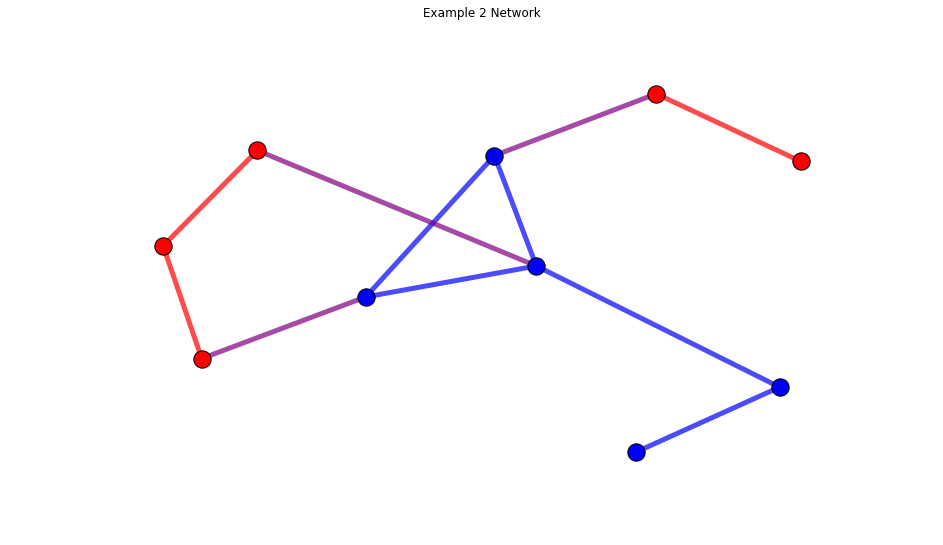

In [3]:
red = ["a", "b", "c", "d", "e"]
blue = ["1", "2", "3", "4", "5"]

rr = [("a", "b"), ("b", "c"), ("d", "e")]
rb = [("1", "d"), ("2", "c"), ("3", "a")]
bb = [("1", "2"), ("2", "3"), ("1", "3"), ("3", "4"), ("4", "5")]

g = nx.Graph()
for node in itt.chain(red, blue):
    g.add_node(node)

for edge in itt.chain(rr, bb, rb):
    g.add_edge(*edge)
    
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=red, node_color='red')
nx.draw_networkx_nodes(g, pos, nodelist=blue, node_color='blue')
nx.draw_networkx_edges(g, pos, edgelist=rr, alpha=0.7, width=5, edge_color='red')
nx.draw_networkx_edges(g, pos, edgelist=bb, alpha=0.7, width=5, edge_color='blue') 
nx.draw_networkx_edges(g, pos, edgelist=rb, alpha=0.7, width=5, edge_color='purple')

plt.axis('off')
plt.title("Example 2 Network")
plt.show()

# Example 3: Simple Heterogeneous Network

This heterogeneous network wil contain two classes, $A=\{a_1 \dots a_n\}$ and $B=\{b_1 \dots b_m\}$

## Edge Choices

Edges will be chosen randomly as follows:
- $P(\{a_1,a_2\} \in E) \sim Uniform(p_{a,a}) \quad a_1,a_2 \in A$ 
- $P(\{b_1,b_2\} \in E) \sim Uniform(p_{b,b}) \quad b_1,b_2 \in B$ 
- $P(\{a, b\} \in E) \sim Uniform(p_{a,b}) \quad a\in A, b \in B$ 

## Expected Number of Edges

- A-A expects ${|A| \choose 2} * p_{a,a}$
- B-B expects ${|B| \choose 2} * p_{b,b}$
- A-B expects $|A| * |B| * p_{a,b}$

This situation returns to the traditional random binomial graph over $G(m+n, p)$ when $p=p_{a,a}=p_{a,b}=p_{b,b}$ 

Total Expected Edges = ${n \choose 2} * p_{a,a} + {m \choose 2} * p_{b,b} + nm * p_{a,b}$

## Degree Distribution

We're taking advantage of the fact that each of these parts were chosen randomly from different distributions. A mathematical look at this is written up at the end.

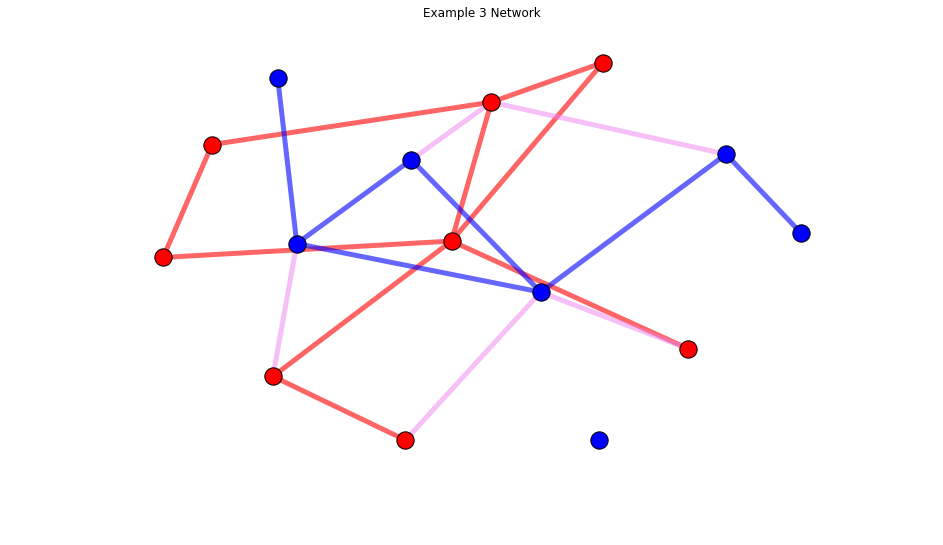

In [4]:
# represent class sizes as array
n_r, n_b = 8, 7
# represent probabilities as squashed upper triangular matrix
p_rr, p_rb, p_bb = 0.30, 0.15, 0.25

r = list(range(n_r))
b = list(range(n_r, n_r + n_b))

rr_edges = [x for x in combinations(r, 2) if uniform() < p_rr]
bb_edges = [x for x in combinations(b, 2) if uniform() < p_bb]
rb_edges = [x for x in product(r, b) if uniform() < p_rb]

g = nx.Graph()

for node in itt.chain(r, b):
    g.add_node(node)

for edge in itt.chain(rr_edges, bb_edges, rb_edges):
    g.add_edge(*edge)
    
pos = nx.spring_layout(g)

nx.draw_networkx_nodes(g, pos, nodelist=r, node_color='r')
nx.draw_networkx_nodes(g, pos, nodelist=b, node_color='b')

nx.draw_networkx_edges(g, pos, edgelist=rr_edges, width=5, alpha=0.6, edge_color='red')
nx.draw_networkx_edges(g, pos, edgelist=bb_edges, width=5, alpha=0.6, edge_color='blue') 
nx.draw_networkx_edges(g, pos, edgelist=rb_edges, width=5, alpha=0.5, edge_color='violet') 

plt.title("Example 3 Network")
plt.axis('off')
plt.show()

# Example 4: Arbitrary Number of Classes


## Parameter Wrapper
Given ${n}$ classes, there are $n$ integer parameters for class sizes, $n^2$ double parameters for probabilities (including self probabilities and cross probabilities).


The probability parameters are arranged in an $n \times n$ matrix. Where the $A_{i,j}$ represents the probability that an edge between an element in class $i$ and $j$ is chosen when constructing an Erdos-Reyni Random Graph.

In [5]:
class MGParams:
    def __init__(self, sizes, p, colors):
        self.sizes = sizes
        self.p = np.array(p)
        self.colors = colors
        self.n = len(sizes)
        
        if not len(sizes) == len(p) == len(colors):
            raise 'invalid input'

## Graph Generator

In [6]:
class MG:
    def __init__(self, params):
        self.params = params
        self.node_groups = {}
        self.se_sets = {}
        self.ce_sets = {}
        self.pos = None
        self.graph = nx.Graph()
    
    def generate(self):
        # Build Graph
        prev = 0
        for group, acc in enumerate(accumulate(self.params.sizes)):
            self.node_groups[group] = list(range(prev, acc))
            prev = acc

        for i, node_group in self.node_groups.items():
            self.se_sets[i] = [x for x in combinations(node_group, 2) if uniform() < self.params.p[i, i]]

        for c1, c2 in combinations(range(self.params.n), 2):
            self.ce_sets[c1, c2] = [x for x in product(self.node_groups[c1], self.node_groups[c2]) 
                                        if uniform() < self.params.p[c1, c2]]
        
        # Add to NetworkX Graph
        for i, node_group in self.node_groups.items():
            for node in node_group:
                self.graph.add_node(node, group=i)

        for se_set in self.se_sets.values():
            for edge in se_set:
                self.graph.add_edge(*edge)

        for ce_set in self.ce_sets.values():
            for edge in ce_set:
                self.graph.add_edge(*edge)

    def position(self):
        self.pos = nx.circular_layout(self.graph)
                
    def draw(self, title=None):
        for i, node_group in self.node_groups.items():
            nx.draw_networkx_nodes(self.graph, 
                                   self.pos, 
                                   nodelist=node_group, 
                                   node_color=self.params.colors[i])

        for i, se_set in self.se_sets.items():
            nx.draw_networkx_edges(self.graph, 
                                   self.pos, 
                                   edgelist=se_set, 
                                   edge_color=self.params.colors[i],  
                                   width=5, 
                                   alpha=0.5)

        for i, ce_set in self.ce_sets.items():
            nx.draw_networkx_edges(self.graph, 
                                   self.pos, 
                                   edgelist=ce_set, 
                                   edge_color='grey',  
                                   width=5, 
                                   alpha=0.5) 
        if title:
            plt.title(title)
        plt.axis('off')
        plt.show()
    
    def do(self, title=None):
        self.generate()
        self.position()
        self.draw(title)

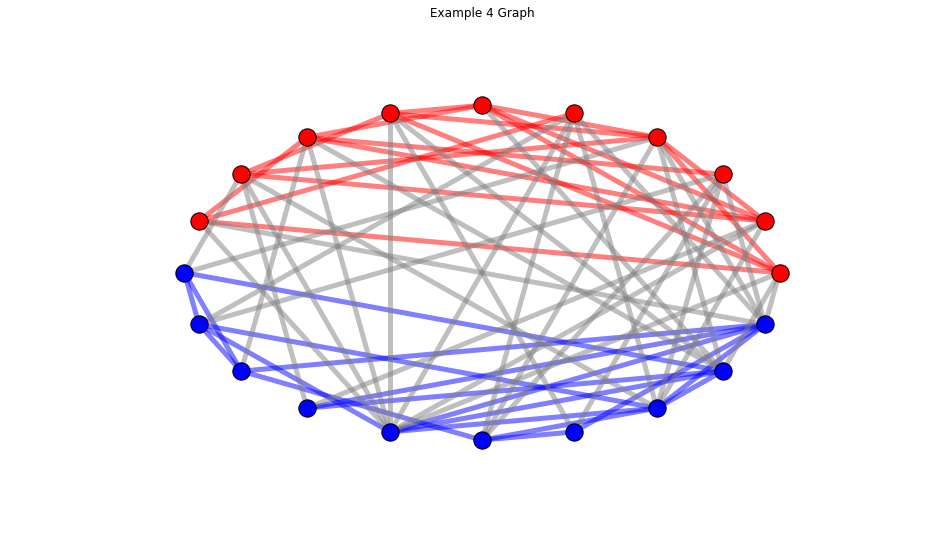

In [7]:
t1 = MGParams(sizes=[10,10], p=[[0.3, 0.3], [0.3, 0.3]], colors=["red", "blue"])
mg = MG(t1)
mg.do("Example 4 Graph")

# Degree Distribution

## Composite Degree Distribution

NameError: name 'degrees' is not defined

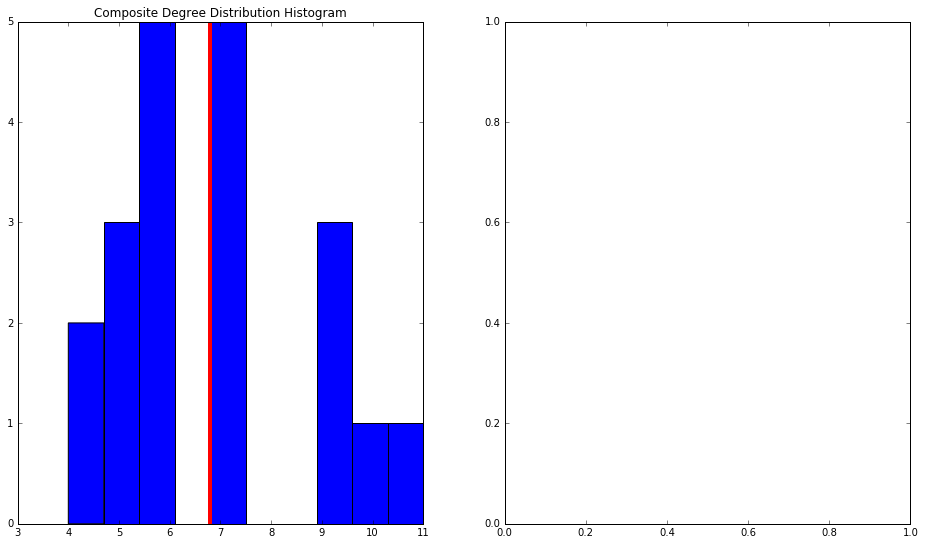

In [9]:
f, ax = plt.subplots(1, 2)

comp_degrees = list(nx.degree(mg.graph).values())
ax[0].hist(comp_degrees)
ax[0].set_title("Composite Degree Distribution Histogram")
ax[0].axvline(np.average(comp_degrees), color='red', linewidth=4)

max_degrees = max(comp_degrees)
for color in mg.params.colors:
    degrees[color].hist(alpha=0.4, color=color, bins=20, range=(0, max_degrees), ax=ax[1])
ax[1].set_title("$deg_{blue}$ distribution in blue and \n $deg_{red}$ distribution in red")

## Multivariate Degree Distribution 

In [10]:
# calculate degrees dictionary node:{c1:X, c2:Y, c3:Z}
degrees = {node: np.zeros(mg.params.n) for node in mg.graph.nodes()}
for n1, n2, data in mg.graph.edges(data=True):
    degrees[n1][mg.graph.node[n2]['group']] += 1
    degrees[n2][mg.graph.node[n1]['group']] += 1

degrees = pd.DataFrame(degrees, index=mg.params.colors).T
degrees.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
red,4,4,1,5,1,5,4,4,3,3,2,2,1,2,7,3,2,4,5,5
blue,3,3,5,4,5,1,3,3,4,2,3,4,4,2,4,3,2,5,4,5


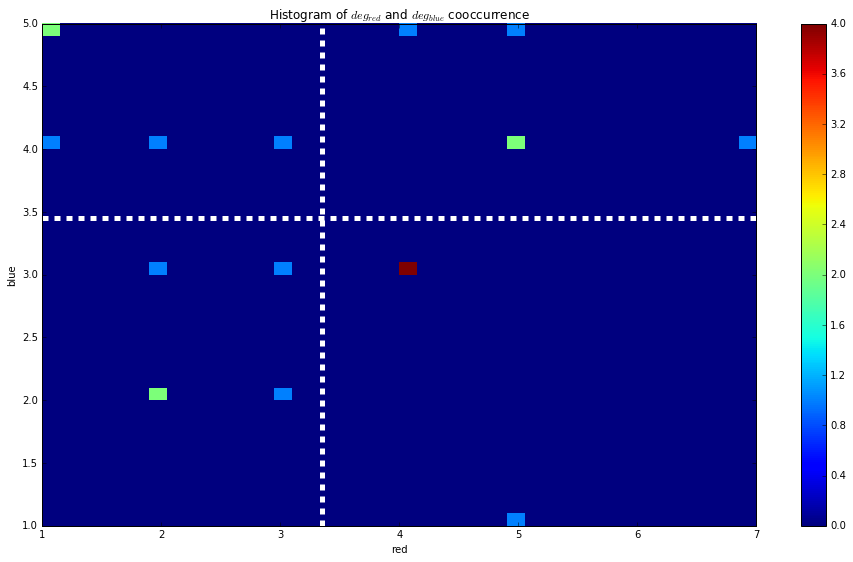

In [12]:
plt.title("Histogram of $deg_{red}$ and $deg_{blue}$ cooccurrence")
plt.hist2d(degrees.values[:,0], degrees.values[:,1], bins=40)
plt.xlabel(mg.params.colors[0])
plt.ylabel(mg.params.colors[1])

# Draw Averages
plt.axvline(np.average(degrees.values[:,0]), color='white', linewidth=5, ls="dashed")
plt.axhline(np.average(degrees.values[:,1]), color='white', linewidth=5, ls="dashed")

plt.colorbar()
plt.show()

# References
- https://networkx.github.io/documentation/latest/examples/drawing/labels_and_colors.html

# Appendix

## Statistical Derivations on Binary Node Network

Recall this is a network of nodes with one of two labels. There are different probabilities for connections of nodes of type A to other nodes of type A, nodes of type A to type B, and nodes of type B to other nodes of type B.


### Membership in Classes within Network


$P(v \in A) = \frac{|A|}{|A| + |B|} = \frac{n}{n+m}$

$P(v \in B) = \frac{|B|}{|A| + |B|} = \frac{m}{n+m}$

$P(v \in B) + P(v \in A) = \frac{n}{n+m} + \frac{m}{n+m} = 1$

### Conditional Probabilities Given a Node's Class

||$v \in A$|$v \in B$|
|:-------------:|:---------:|:-----------------:|
|$P(deg_A(v)=k)$ |${|A|-1 \choose k}p_{aa}^k(1-p_{aa})^{|A|-1-k}$|${|A| \choose k}p_{ab}^k(1-p_{ab})^{|A|-k}$|
|$P(deg_B(v)=k)$ |${|B| \choose k}p_{ab}^k(1-p_{ab})^{|B|-k}$|${|B|-1 \choose k}p_{bb}^k(1-p_{bb})^{|B|-1-k}$|

#### A Connections
$P(deg_A(v)=k \mid v \in A)={|A|-1 \choose k}p_{aa}^k(1-p_{aa})^{|A|-1-k}$

$P(deg_B(v)=k \mid v \in A)={|B| \choose k}p_{ab}^k(1-p_{ab})^{|B|-k}$

A node connections to other A nodes and B nodes are sampled independently, so the joint probability distrubution is:

$P(deg_A(v)=k, deg_B(v)=l \mid v \in A) = {|A|-1 \choose k}p_{aa}^k(1-p_{aa})^{|A|-1-k} \times {|B| \choose l}p_{ab}^l(1-p_{ab})^{|B|-l}$

#### B Connections

$P(deg_A(v)=k \mid v \in B)={|A| \choose k}p_{ab}^k(1-p_{ab})^{|A|-k}$

$P(deg_B(v)=k \mid v \in B)={|B|-1 \choose k}p_{bb}^k(1-p_{bb})^{|B|-1-k}$

With the same reasoning for A nodes' connections, the joint probability distribution of a B node is:

$P(deg_A(v)=k, deg_B(v)=l \mid v \in B)={|A| \choose k}p_{ab}^k(1-p_{ab})^{|A|-k} \times {|B|-1 \choose l}p_{bb}^l(1-p_{bb})^{|B|-1-l}$

### Combine
We can also take a different approach where we try and find the A degree distribtuion and B degree distributions using the Law of Total Probability. Recall that it states $P(A)=\sum \limits_{n}P(A \mid B_n)*P(B_n)$ - when all the possible $B_n$'s make up the whole sample space.

How can we combine these to get the whole distribution over $deg_A(v)$ and eventually the joint distribution $deg(v)=deg_A(v)+deg_B(v)$

$P(deg_A(v)=k) = P(deg_A(v)=k \mid v \in A)*P(v \in A) + P(deg_A(v)=k \mid v \in B)*P(v \in B)\\=\frac{n}{n+m}{|A|-1 \choose k}p_{aa}^k(1-p_{aa})^{|A|-1-k} + \frac{m}{n+m}{|A| \choose k}p_{ab}^k(1-p_{ab})^{|A|-k}$

and similarly:

$P(deg_B(v)=k) = P(deg_B(v)=k \mid v \in A)*P(v \in A) + P(deg_B(v)=k \mid v \in B)*P(v \in B)\\=\frac{n}{n+m}{|B| \choose k}p_{ab}^k(1-p_{ab})^{|B|-k} + \frac{m}{n+m}{|B|-1 \choose k}p_{bb}^k(1-p_{bb})^{|B|-1-k}*$

$P(deg_A(v)=k, deg_B(v)=l \mid v \in A) = {|A|-1 \choose k}p_{aa}^k(1-p_{aa})^{|A|-1-k} \times {|B| \choose l}p_{ab}^l(1-p_{ab})^{|B|-l}$

### Finally
This can be arrived at by combining the joint probabilities for A/B nodes with the law of total probability, or combining the A/B degree distributions with the notion of independence. The final equation is:

$P(deg_A(v)=k, deg_B(v)=l) = \frac{n}{n+m}{|A|-1 \choose k}p_{aa}^k(1-p_{aa})^{|A|-1-k} \times {|B| \choose l}p_{ab}^l(1-p_{ab})^{|B|-l} + \frac{m}{n+m}{|A| \choose k}p_{ab}^k(1-p_{ab})^{|A|-k} \times {|B|-1 \choose l}p_{bb}^l(1-p_{bb})^{|B|-1-l}$

### Goals Equations/Values
- $P(deg(v)=k)=\sum\limits_{r=0}^k P(deg_A(v)=k-r, deg_B(v)=r)$